In [1]:
%load_ext autotime

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from keras.applications.densenet import DenseNet169
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import optimizers
from keras import metrics
from keras import models

from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras_tqdm import TQDMNotebookCallback
from ipywidgets import IntProgress, HTML, HBox


from pathlib import Path
import pickle

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


time: 1.23 s


In [3]:
import logging

log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

time: 905 µs


In [4]:
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

time: 1.35 s


In [5]:
import utils # importing from our utils functions

time: 3.69 s


In [6]:
x_train, y_train, x_test, y_test = utils.read_mura_pickle()
x_train = utils.normalize_pixels(x_train)
x_test = utils.normalize_pixels(x_test)

INFO:utils.utils:loading data/MURA-v1.1/x_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/x_valid.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_valid.pkl


time: 6.19 s


In [7]:
x_train.shape

(36808, 256, 256)

time: 3.45 ms


In [8]:
size = x_train.shape[1]
x_train = x_train.reshape(x_train.shape[0], size, size, 1)
x_test = x_test.reshape(x_test.shape[0], size, size, 1)

time: 5.61 ms


# Train Submodel

In [9]:
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=[1.0, 1.2],
    fill_mode = 'constant',
    cval=0,
    horizontal_flip=True,
    vertical_flip=True)

time: 2.01 ms


In [10]:
datagen.fit(x_train)

time: 4.03 s


In [11]:
with open('trained_models/3_6_densenet169_no_top_inv.pkl', 'rb') as pkl:
    weights = pickle.load(pkl)

time: 34.1 ms


In [12]:
with tf.device('/GPU:0'):
    densenet = DenseNet169(input_shape=(256, 256, 1), classes=1, weights=None, include_top=False)
    densenet.set_weights(weights)
    for layer in densenet.layers:
        layer.trainable = False
    model = models.Model(input=densenet.input, output=layers.Dense(1, activation='sigmoid')(layers.Flatten()(densenet.output)))

time: 22.3 s


In [12]:
starting_epoch = 0
train_round = 0
batch_size = 16
epochs_per_eval = 10
epochs_per_save = 30
total_epochs = 30
# optimizer = 'adam'
# lr = 0.001
train_history = {'loss': [], 'binary_accuracy': [], 'learn_rate': []}
val_per_image_history = {'accuracy': [], 'kappa': [], 'precision': [], 'recall': []}
val_per_study_history = {'accuracy': [], 'kappa': [], 'precision': [], 'recall': []}
model_name='3_7_shared_densenet169_inv'

time: 1.29 ms


In [13]:
def weighted_binary_crossentropy(p1):
    '''
    p1 is the proportion of ones in population
    '''
    w0 = K.variable(p1)
        
    def loss(y_true, y_pred):
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = -(1 - w0) * y_true * K.log(y_pred) - w0 * (1 - y_true) * K.log(1 - y_pred)
        loss = K.sum(loss, -1)
        return loss
    
    return loss

time: 1.91 ms


In [14]:
p1 = y_train.mean()

time: 818 µs


In [16]:
# clr = utils.clr.CyclicLR(mode='triangular2')
# opt = optimizers.SGD(nesterov=True)
opt = optimizers.Adam()

time: 24.6 ms


In [16]:
progress = TQDMNotebookCallback(leave_inner=True, leave_outer=True) 

time: 657 µs


INFO:__main__:executing epochs 1-10


INFO:utils.mura_metrics:Accuracy: 0.6243353143572099
INFO:utils.mura_metrics:Kappa: 0.23477221222073474
INFO:utils.mura_metrics:Precision: 0.6786102062975027
INFO:utils.mura_metrics:Recall: 0.4084967320261438


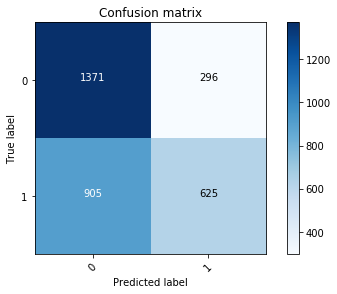

INFO:utils.mura_metrics:Accuracy: 0.6363636363636364
INFO:utils.mura_metrics:Kappa: 0.22758999757681778
INFO:utils.mura_metrics:Precision: 0.6976744186046512
INFO:utils.mura_metrics:Recall: 0.3345724907063197


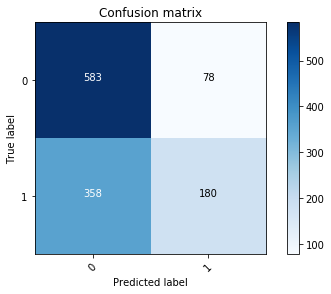

INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 11-20


INFO:utils.mura_metrics:Accuracy: 0.5658429777916797
INFO:utils.mura_metrics:Kappa: 0.09921870940082099
INFO:utils.mura_metrics:Precision: 0.7795275590551181
INFO:utils.mura_metrics:Recall: 0.12941176470588237


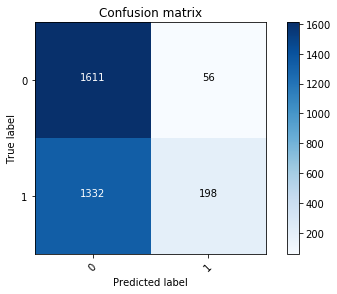

INFO:utils.mura_metrics:Accuracy: 0.5838198498748958
INFO:utils.mura_metrics:Kappa: 0.08211688070607703
INFO:utils.mura_metrics:Precision: 0.8545454545454545
INFO:utils.mura_metrics:Recall: 0.08736059479553904


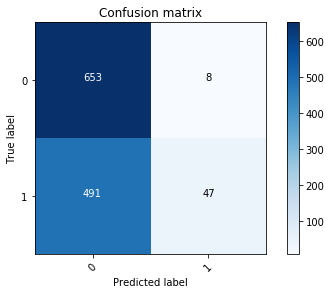

INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 21-30


INFO:utils.mura_metrics:Accuracy: 0.583984985924304
INFO:utils.mura_metrics:Kappa: 0.1395872699686311
INFO:utils.mura_metrics:Precision: 0.7717391304347826
INFO:utils.mura_metrics:Recall: 0.18562091503267975


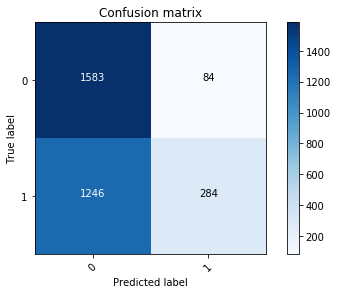

INFO:utils.mura_metrics:Accuracy: 0.5988323603002502
INFO:utils.mura_metrics:Kappa: 0.11954658219151947
INFO:utils.mura_metrics:Precision: 0.8518518518518519
INFO:utils.mura_metrics:Recall: 0.12825278810408922


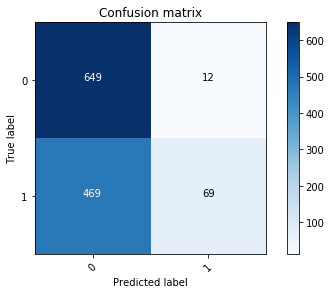

INFO:__main__:Saving Model to trained_models/3_7_shared_densenet169_inv_30.h5...
INFO:__main__:Saving evaluation metrics history...


time: 2h 8min 8s


In [19]:
while (train_round+1) * epochs_per_eval + starting_epoch <= total_epochs:
    log.info(f'executing epochs {train_round * epochs_per_eval + 1 + starting_epoch}-{(train_round+1) * epochs_per_eval + starting_epoch}')
    
#     if train_round * epochs_per_eval + 1 + starting_epoch >= 10:
#         if np.mean(train_history['loss'][-10:-5]) < np.mean(train_history['loss'][-5:]): # if no improvements in 5 epochs
#             if optimizer == 'adam':
#                 log.info(f'switching to SGD with lr={lr}')
#                 optimizer = 'sgd'
#             else:
#                 log.info(f'reducing SGD learn rate from {lr} to {lr * 0.8}')
#                 lr = lr * 0.8
#             opt = optimizers.SGD(lr=lr, momentum=0.9, nesterov=True)
#         else:
#             if optimizer == 'adam':
#                 opt = optimizers.Adam(lr=lr)
#             else:
#                 opt = optimizers.SGD(lr=lr, momentum=0.9, nesterov=True)
#     else:
#         opt = optimizers.Adam(lr=lr)

    model.compile(
        loss=weighted_binary_crossentropy(p1),
        optimizer=opt,
        metrics=[metrics.binary_accuracy])
    
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                           steps_per_epoch = int(np.round(len(x_train) / batch_size)),
                           epochs=epochs_per_eval, verbose=0,
                           callbacks=[progress])
                           # callbacks=[clr, TQDMNotebookCallback()])
    
    # train_history['learn_rate'].extend(clr.history['lr'])
    train_history['loss'].extend(model.history.history['loss'])
    train_history['binary_accuracy'].extend(model.history.history['binary_accuracy'])
    
    y_valid_hat = model.predict(x_test)
    true_label = np.round(y_test)
    pred_label = np.round(y_valid_hat)
    evaluate = utils.MURAMetrics(true_label, pred_label)
    
    per_image_metrics = evaluate.report_by_image()
    for key in per_image_metrics:
        val_per_image_history[key].append(per_image_metrics[key])
    
    per_study_metrics = evaluate.report_by_study()
    for key in per_image_metrics:
        val_per_study_history[key].append(per_study_metrics[key])
    
    cur_epoch = (train_round + 1) * epochs_per_eval
    if cur_epoch % epochs_per_save == 0:
        log.info(f'Saving Model to trained_models/{model_name}_{cur_epoch + starting_epoch}.h5...')
        model.save(f'./trained_models/{model_name}_{cur_epoch + starting_epoch}.h5')
    weighted_binary_crossentropy(p1)
    log.info('Saving evaluation metrics history...')
    with open(f'./trained_models/{model_name}_train_history.pkl', 'wb') as pkl_file:
        pickle.dump(train_history, pkl_file)
    with open(f'./trained_models/{model_name}_val_per_image_history.pkl', 'wb') as pkl_file:
        pickle.dump(val_per_image_history, pkl_file)
    with open(f'./trained_models/{model_name}_val_per_study_history.pkl', 'wb') as pkl_file:
        pickle.dump(val_per_study_history, pkl_file)
    
    train_round += 1

time: 605 µs
